In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

#Data preprocessing

In [ ]:
ground_truth = pd.read_excel('/content/ground_truth.xlsx')
ground_truth.head()

,file,truth_label,truth_bbox
0,Image_AY1ZWZD5.jpg,0,NaN
1,Image_B2Z6BH7R.jpg,0,NaN
2,Image_YTXYC9BS.jpg,0,NaN
3,Image_DBX2S91J.jpg,1,"[0.678, 0.20457, 0.4364, 0.24793]"
4,Image_CPZW8OAO.jpg,1,"[0.48533, 0.426627, 0.45522, 0.64988]"


In [ ]:
predictions = pd.read_excel('/content/predictions.xlsx')
predictions.head()

,file,pred_label,pred_bbox
0,Image_AY1ZWZD5.jpg,0,NaN
1,Image_B2Z6BH7R.jpg,0,NaN
2,Image_YTXYC9BS.jpg,1,"[0.56886, 0.476772, 0.35424, 0.580991]"
3,Image_DBX2S91J.jpg,1,"[0.63865, 0.198551, 0.4647, 0.298822]"
4,Image_CPZW8OAO.jpg,1,"[0.47552, 0.422169, 0.4088, 0.594699]"


In [ ]:
def width_height(file_name):
  im = Image.open(f"/content/images/{file_name}")
  width, height = im.size
  return [width, height]

In [ ]:
df_truth_pred = ground_truth.merge(predictions, on='file')
df_truth_pred['truth_bbox'] = df_truth_pred['truth_bbox'].apply(lambda x: [float(coord) for coord in x.strip('[]').split(', ')] if pd.notnull(x) else None)
df_truth_pred['pred_bbox'] = df_truth_pred['pred_bbox'].apply(lambda x: [float(coord) for coord in x.strip('[]').split(', ')] if pd.notnull(x) else None)
df_truth_pred['width_height'] = df_truth_pred.file.apply(lambda x: width_height(x))
df_truth_pred.head()

,file,truth_label,truth_bbox,pred_label,pred_bbox,width_height
0,Image_AY1ZWZD5.jpg,0,None,0,None,"[1024, 1024]"
1,Image_B2Z6BH7R.jpg,0,None,0,None,"[1024, 1024]"
2,Image_YTXYC9BS.jpg,0,None,1,"[0.56886, 0.476772, 0.35424, 0.580991]","[500, 333]"
3,Image_DBX2S91J.jpg,1,"[0.678, 0.20457, 0.4364, 0.24793]",1,"[0.63865, 0.198551, 0.4647, 0.298822]","[200, 314]"
4,Image_CPZW8OAO.jpg,1,"[0.48533, 0.426627, 0.45522, 0.64988]",1,"[0.47552, 0.422169, 0.4088, 0.594699]","[500, 332]"


In [ ]:
truth_box = []
pred_box = []

for t_box, p_box, size in zip(df_truth_pred.truth_bbox, df_truth_pred.pred_bbox, df_truth_pred.width_height):
  if t_box is None:
    truth_box.append(None)
  else:
    truth_box.append([t_box[0] * size[0], t_box[1] * size[1], t_box[2] * size[0], t_box[3] * size[1]])

  if p_box is None:
    pred_box.append(None)
  else:
    pred_box.append([p_box[0] * size[0], p_box[1] * size[1], p_box[2] * size[0], p_box[3] * size[1]])

df_truth_pred['truth_bbox'] = truth_box
df_truth_pred['pred_bbox'] = pred_box
df_truth_pred.head()

,file,truth_label,truth_bbox,pred_label,pred_bbox,width_height
0,Image_AY1ZWZD5.jpg,0,None,0,None,"[1024, 1024]"
1,Image_B2Z6BH7R.jpg,0,None,0,None,"[1024, 1024]"
2,Image_YTXYC9BS.jpg,0,None,1,"[284.43, 158.765076, 177.12, 193.47000300000002]","[500, 333]"
3,Image_DBX2S91J.jpg,1,"[135.60000000000002, 64.23498000000001, 87.28,...",1,"[127.73, 62.345014, 92.94, 93.830108]","[200, 314]"
4,Image_CPZW8OAO.jpg,1,"[242.665, 141.640164, 227.61, 215.76016]",1,"[237.76, 140.160108, 204.4, 197.440068]","[500, 332]"


#Confusion matrix

In [ ]:
Y_true = df_truth_pred.truth_label
Y_preds = df_truth_pred.pred_label

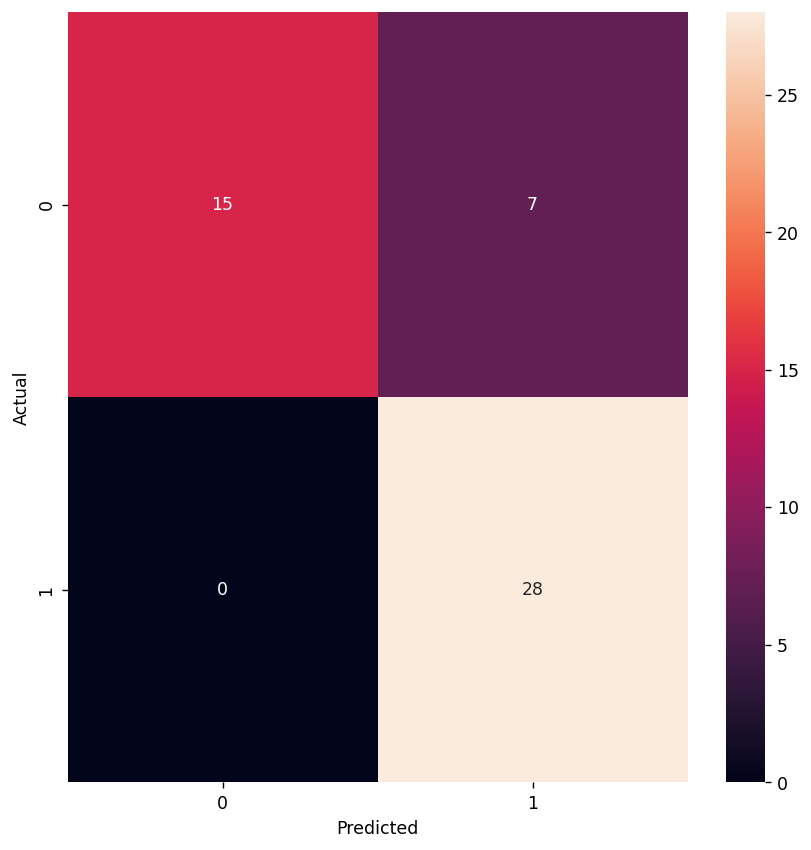

In [ ]:
conf_mat = confusion_matrix(Y_true, Y_preds)
fig, ax = plt.subplots(figsize=(8,8), dpi = 125)
sns.heatmap(conf_mat, annot=True, fmt='d',
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#False positive examples

In [ ]:
false_positive = df_truth_pred[df_truth_pred.truth_label != df_truth_pred.pred_label]

for pic, box in zip(false_positive['file'], false_positive.pred_bbox):
  rect = patches.Rectangle((box[0] - box[2]/2, box[1] - box[3]/2), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
  im = Image.open(f"/content/images/{pic}")
  fig, ax = plt.subplots()
  ax.imshow(im)
  ax.add_patch(rect)
  ax.axis('off')
  plt.show()

#Intersection Over Union

In [ ]:
def IOU(t_box, p_box):
    x1_min = t_box[0] - t_box[2]/2
    y1_min = t_box[1] - t_box[3]/2
    x1_max = t_box[0] + t_box[2]/2
    y1_max = t_box[1] + t_box[3]/2
    
    x2_min = p_box[0] - p_box[2]/2
    y2_min = p_box[1] - p_box[3]/2
    x2_max = p_box[0] + p_box[2]/2
    y2_max = p_box[1] + p_box[3]/2
    
    x_intersection_min = max(x1_min, x2_min)
    y_intersection_min = max(y1_min, y2_min)
    x_intersection_max = min(x1_max, x2_max)
    y_intersection_max = min(y1_max, y2_max)
    
    intersection_area = max(0, x_intersection_max - x_intersection_min) * max(0, y_intersection_max - y_intersection_min)
    
    box1_area = t_box[2] * t_box[3]
    box2_area = p_box[2] * p_box[3]
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

In [ ]:
df_true_positive = df_truth_pred.where((df_truth_pred.truth_label == 1) & (df_truth_pred.truth_label == df_truth_pred.pred_label))
df_true_positive = df_true_positive.drop(['truth_label', 'pred_label', 'width_height'], axis = 1)
df_true_positive = df_true_positive.dropna(axis = 0)
df_true_positive['IOU'] = [IOU(t_box, p_box) for t_box, p_box in zip(df_true_positive.truth_bbox, df_true_positive.pred_bbox)]
df_true_positive.head()

,file,truth_bbox,pred_bbox,IOU
3,Image_DBX2S91J.jpg,"[135.60000000000002, 64.23498000000001, 87.28,...","[127.73, 62.345014, 92.94, 93.830108]",0.702560
4,Image_CPZW8OAO.jpg,"[242.665, 141.640164, 227.61, 215.76016]","[237.76, 140.160108, 204.4, 197.440068]",0.821776
5,Image_CVRESW2M.jpg,"[234.58480000000003, 79.689948, 120.35, 118.85...","[232.79000000000002, 76.84982000000001, 110.2,...",0.826608
8,Image_ACCFVSLA.jpg,"[183.14505, 58.994991000000006, 56.02987500000...","[102.4199, 85.91502299999999, 55.49995, 56.669...",0.000000
10,Image_HSGPZGBX.jpg,"[276.02500000000003, 145.075036, 150.91, 146.5...","[275.71000000000004, 146.0551, 133.94, 134.8501]",0.816690


In [ ]:
df_true_positive.IOU.mean()

0.5825282929442412

#Poor IOU cause

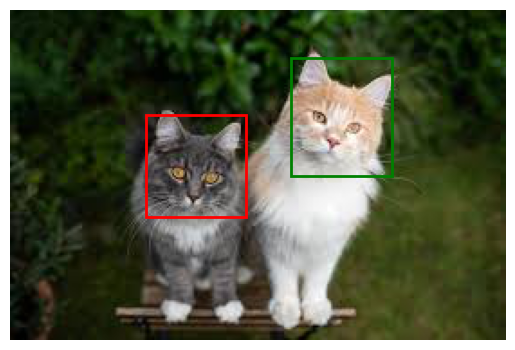

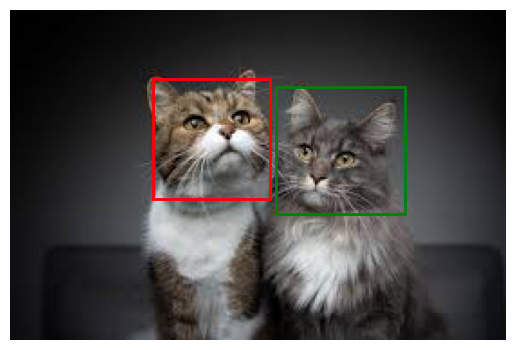

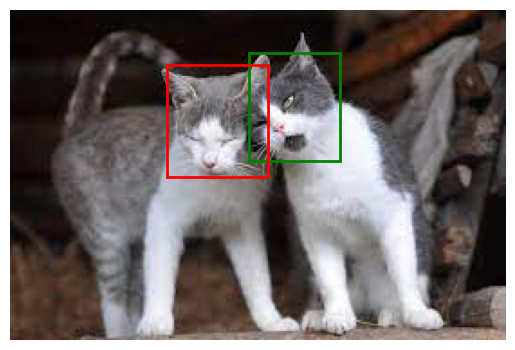

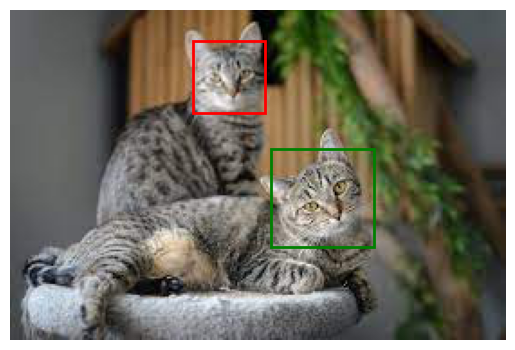

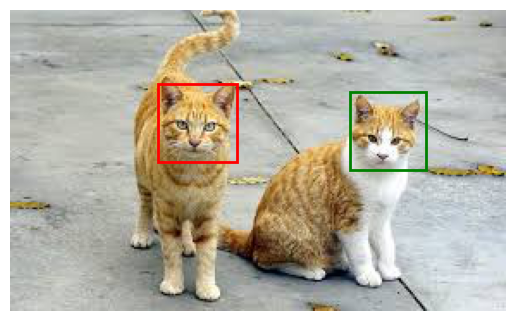

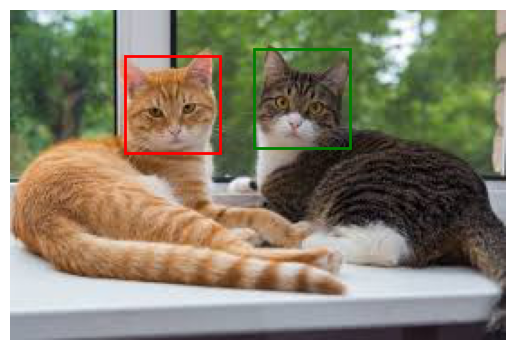

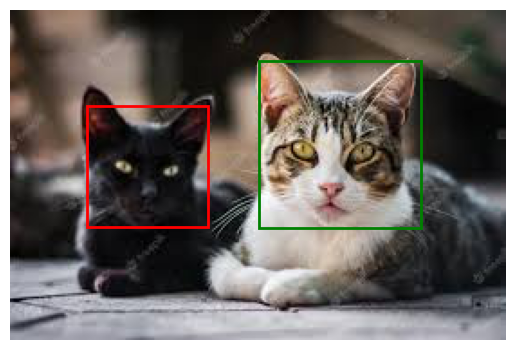

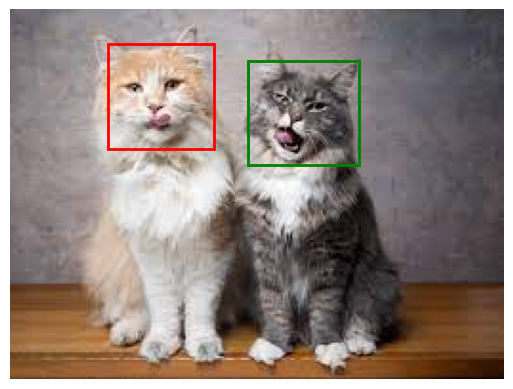

In [ ]:
poor_iou = df_true_positive[df_true_positive.IOU < 0.1]

for pic, t_box, p_box in zip(poor_iou['file'], poor_iou.truth_bbox, poor_iou.pred_bbox):
  t_rect = patches.Rectangle((t_box[0] - t_box[2]/2, t_box[1] - t_box[3]/2), t_box[2], t_box[3], linewidth=2, edgecolor='g', facecolor='none')
  p_rect = patches.Rectangle((p_box[0] - p_box[2]/2, p_box[1] - p_box[3]/2), p_box[2], p_box[3], linewidth=2, edgecolor='r', facecolor='none')
  im = Image.open(f"/content/images/{pic}")
  fig, ax = plt.subplots()
  ax.imshow(im)
  ax.add_patch(t_rect)
  ax.add_patch(p_rect)
  ax.axis('off')
  plt.show()

#IOU without two targets

In [ ]:
df_true_positive[df_true_positive.IOU > 0.1].IOU.mean()

0.8107947367871138

#Good IOU examples

In [ ]:
good_iou = df_true_positive[df_true_positive.IOU > 0.1]

for pic, t_box, p_box in zip(good_iou['file'], good_iou.truth_bbox, good_iou.pred_bbox):
  t_rect = patches.Rectangle((t_box[0] - t_box[2]/2, t_box[1] - t_box[3]/2), t_box[2], t_box[3], linewidth=2, edgecolor='g', facecolor='none')
  p_rect = patches.Rectangle((p_box[0] - p_box[2]/2, p_box[1] - p_box[3]/2), p_box[2], p_box[3], linewidth=2, edgecolor='r', facecolor='none')
  im = Image.open(f"/content/images/{pic}")
  fig, ax = plt.subplots()
  ax.imshow(im)
  ax.add_patch(t_rect)
  ax.add_patch(p_rect)
  ax.axis('off')
  plt.show()

#True Negative examples

In [ ]:
true_negative = df_truth_pred['file'][(df_truth_pred.truth_label == 0) & (df_truth_pred.pred_label == 0)].values

for pic in true_negative:
  im = Image.open(f"/content/images/{pic}")
  im.show()

#Evaluating classification

In [ ]:
print(classification_report(Y_true, Y_preds))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        22
           1       0.80      1.00      0.89        28

    accuracy                           0.86        50
   macro avg       0.90      0.84      0.85        50
weighted avg       0.89      0.86      0.85        50



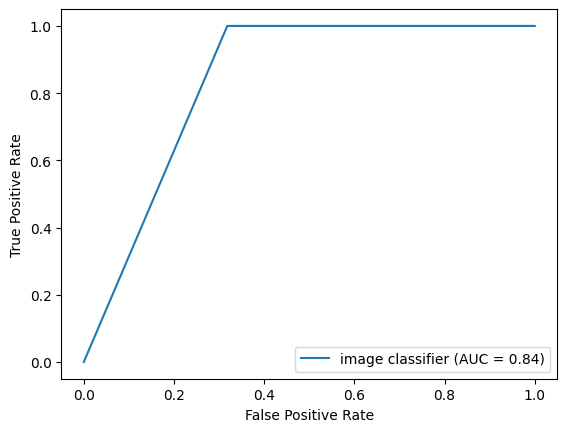

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_true, Y_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='image classifier')
display.plot()
plt.show()